In [7]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tt

def assemble_solve_SimplePDE(coeff, getLinearSystem=True):
  """
  Solve simple diffusion problem on [0,1] using P1 finite elements.
  """

  [num_coeff, nx, I] = np.shape(coeff)

  coeff = coeff[0,:,:]

  if np.min(coeff) <= 0:
    warnings.warn(f'Non positive components')
  
  A = []
  F = []
  U = []

  for i in range(I):
    Fi = np.full((nx+1,1), 1/(nx)) # assume RHS = 1 
    Fi[[0,-1]] = 0 # boundary condition
    F.append(Fi) 
    Ai = np.zeros((nx+1,nx+1))

    # assemble A, coeff piecewise constant on grid
    Ai.flat[nx+2::nx+2] = (coeff[1:,i] + coeff[:-1, i]) * nx # set diag
    Ai.flat[1::nx+2] = -coeff[:,i] * nx # set first upper diag
    Ai.flat[nx+1::nx+2] = -coeff[:,i] * nx # set first lower diag
    Ai[[0,-1]] = 0
    Ai[0,0] = 1
    Ai[-1,-1] = 1
    A.append(Ai)
    U.append(np.linalg.solve(Ai, F[i]).reshape((-1,1)))

  if getLinearSystem:
    return U,A,F
  else:
    return U


def coeff(X, Nx, Ny, offset, var):
  c = np.full(len(X), offset,dtype=float)
  for i, x in enumerate(X):
    # print(i)
    for k in range(1, len(x)):
      c[i] += np.exp(-k) * np.sin(np.pi*k*x[0]/(Nx-1)) * (x[k]/(Ny-1) - 0.5) * var
  return c

### PDE test

Solve the PDE using P1 finite elements for a random parameter

Text(0, 0.5, 'A')

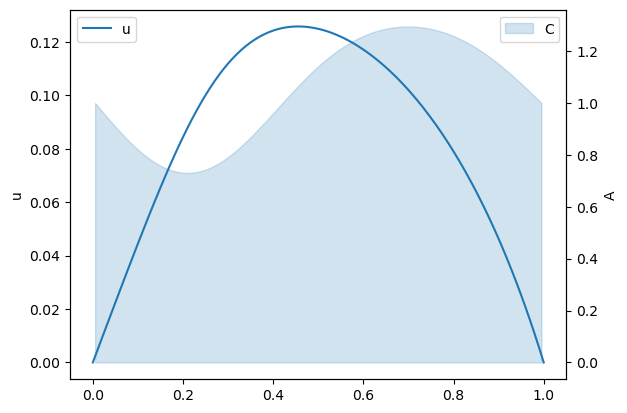

In [8]:
Nx = 100      # spatial resolution
Ny = 10       # parameter resolution
n_param = 5   # number of parameters
offset = 1    # parameter mean
var = 4       # 'variance' of the parameters

# get random params
y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(Nx).reshape((-1,1)), np.tile(y, [Nx,1])])

cfun = lambda x : coeff(x, Nx, Ny, offset, var)

C_true = cfun(X)

U,A,F = assemble_solve_SimplePDE(C_true.reshape(1,-1,1))
U = np.ravel(U)

fig, ax = plt.subplots()
ax2 = ax.twinx()

x = np.arange(Nx+1) / Nx
midpoints = (np.arange(Nx) + 0.5) / Nx
p = ax.plot(x, U, label='u')
ax2.fill_between((np.arange(len(C_true)) + 0.5) / (len(C_true)), C_true, alpha=0.2, color=p[0].get_color(), label='C')

ax.set_ylabel('u')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('A')

### Get TT approx of coefficient

In [9]:
from tt import cross

# random init tensor
C = tt.rand(np.array([Nx] + [Ny] * n_param),r=3)
# compute TT approx using TT-cross
C = tt.cross.rect_cross.cross(cfun, C, eps = 1e-2, kickrank=1)
C = C.round(1e-12)

print("Coefficient ranks: ", C.r)
print("Coefficient dims: ", C.n)

swp: 0/9 er_rel = 1.4e+01 er_abs = 4.7e+04 erank = 5.0 fun_eval: 2160
swp: 1/9 er_rel = 3.3e-02 er_abs = 1.1e+02 erank = 8.0 fun_eval: 6760
swp: 2/9 er_rel = 1.1e-15 er_abs = 3.6e-12 erank = 12.8 fun_eval: 17400
Coefficient ranks:  [1 6 5 4 3 2 1]
Coefficient dims:  [100  10  10  10  10  10]


### Test TT approx

Compare TT approx of coefficient $A$ vs the true coefficient $A$ for the random parameter sample from above

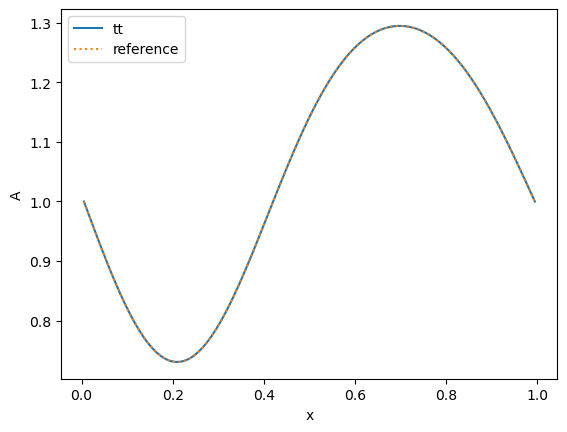

In [10]:
# eval TT-approx of coeff
C_eval = np.empty(Nx)
for i in range(Nx):
  C_eval[i] = C[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

x = (np.arange(0, Nx) + .5) / Nx
ax.plot(x, C_eval, label='tt')
ax.plot(x, C_true, ls='dotted', label="reference")
ax.set_xlabel('x')
ax.set_ylabel('A')
ax.legend()

### ALS-cross test

In [11]:
import als_cross_parametric as alscr
import importlib
importlib.reload(alscr)

u, time, funevals = alscr.als_cross_parametric(C, assemble_solve_SimplePDE, 1e-8, 
                                               nswp=3,
                                               kickrank=5,
                                               random_init=5)

print(f"solve: {time[0]:.3}s, project: {time[1]:.3}s")
print(f"function eval: {funevals}")

=als_cross_parametric= 0 swp=1, max_dx=1.000e+00, max_rank = 6
=als_cross_parametric= swp=1 (1), i=1, dx=1.000e+00, rank =[6, 5]
=als_cross_parametric= swp=1 (1), i=2, dx=1.000e+00, rank =[5, 5]
=als_cross_parametric= swp=1 (1), i=3, dx=1.000e+00, rank =[5, 5]
=als_cross_parametric= swp=1 (1), i=4, dx=1.000e+00, rank =[5, 4]
=als_cross_parametric= fwd swp=1, max_dx=1.000e+00, max_rank =6
=als_cross_parametric= swp=2 (-1), i=5, dx=1.000e+00, rank =[6, 1]
=als_cross_parametric= swp=2 (-1), i=4, dx=3.614e-10, rank =[7, 6]
=als_cross_parametric= swp=2 (-1), i=3, dx=3.116e-06, rank =[8, 7]
=als_cross_parametric= swp=2 (-1), i=2, dx=2.403e-03, rank =[9, 8]
=als_cross_parametric= swp=2 (-1), i=1, dx=1.548e-02, rank =[11, 9]
=als_cross_parametric= 0 swp=3, max_dx=1.000e+00, max_rank = 11
=als_cross_parametric= swp=3 (1), i=1, dx=1.415e-02, rank =[16, 13]
=als_cross_parametric= swp=3 (1), i=2, dx=7.464e-03, rank =[13, 11]
=als_cross_parametric= swp=3 (1), i=3, dx=7.996e-04, rank =[11, 9]
=als_c

### Test ALS-cross accuracy

Compare ALS cross approximation vs PDE solution for a random sample

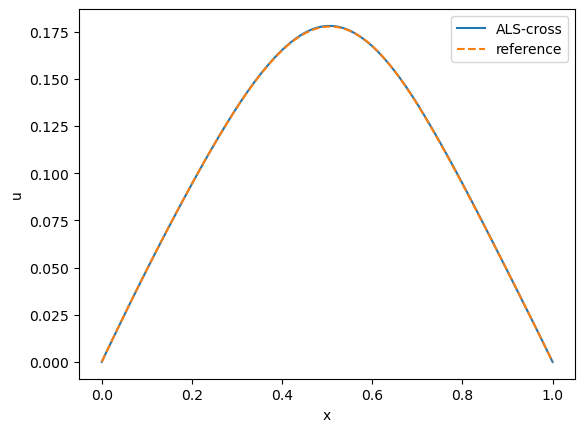

In [12]:
# get random parameter
y = np.random.randint(0,Ny, n_param)
X = np.hstack([np.arange(100).reshape((-1,1)), np.tile(y, [100,1])])

C_true = cfun(X) # compute true coeff

U,A,F = assemble_solve_SimplePDE(C_true.reshape(1,-1,1)) # solve PDE
U = np.ravel(U)

# eval ALS-cross
U_eval = np.empty(u.n[0])
for i in range(u.n[0]):
  U_eval[i] = u[np.concatenate((np.array([i]), y))]

fig, ax = plt.subplots()

x = np.arange(0, Nx+1) / Nx
ax.plot(x, U_eval, label='ALS-cross')
ax.plot(x, U, ls='dashed', label='reference')
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.legend()

#### Test acceleration code

In [18]:
import localcross
import numpy as np

m = 50
n = 13
rng = np.random.default_rng(0)
Y = np.zeros((m,n))
Y += np.outer(rng.random(m), rng.random(n))
Y += np.outer(rng.random(m), rng.random(n)) * 1e-2
Y += np.outer(rng.random(m), rng.random(n)) * 1e-4

tol = 1e-3
%timeit u, v = localcross.localcross(Y, tol=tol, fast=True)
u, v = localcross.localcross(Y, tol=tol, fast=True)

%timeit u2, v2 = localcross.localcross(Y, tol=tol, fast=False)
u2, v2 = localcross.localcross(Y, tol=tol, fast=False)

print(np.allclose(u, u2))
print(np.allclose(v, v2))

10.8 µs ± 42.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
28.1 µs ± 93.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
True
True


In [19]:
import numpy as np
import utils

rng=np.random.default_rng()
ru1 = 13
ru2 = 17
rc1 = 7
n1 = 151
UAU = rng.random((ru1,ru1,rc1))
crC = rng.random((rc1, n1, ru2))
crF = rng.random((ru1, n1*ru2))

%timeit cru = utils.solve_blockdiag(UAU, crC, crF, ru1,ru2,rc1,n1, fast=True)
cru = utils.solve_blockdiag(UAU, crC, crF, ru1,ru2,rc1,n1, fast=True)

%timeit cru2 = utils.solve_blockdiag(UAU, crC, crF, ru1,ru2,rc1,n1, fast=False)
cru2 = utils.solve_blockdiag(UAU, crC, crF, ru1,ru2,rc1,n1, fast=False)

print(np.allclose(cru,cru2))


565 µs ± 6.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
11.8 ms ± 51.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


In [20]:
import numpy as np
import utils

rng=np.random.default_rng()
ru1 = 9
ru2 = 7
rc1 = 5
rc2 = 3
n1 = 150
UAU = rng.random((ru1,ru1,rc1))
crC = rng.random((rc1, n1, rc2))
cru = rng.random((ru1, n1, ru2))

%timeit UAU_new = utils.project_blockdiag(UAU, crC, cru, ru1,ru2,rc1,rc2,n1)
UAU_new = utils.project_blockdiag(UAU, crC, cru, ru1,ru2,rc1,rc2,n1, fast=True)

%timeit UAU_new2 = utils.project_blockdiag(UAU, crC, cru, ru1,ru2,rc1,rc2,n1, fast=False)
UAU_new2 = utils.project_blockdiag(UAU, crC, cru, ru1,ru2,rc1,rc2,n1, fast=False)

print(np.allclose(UAU_new, UAU_new2))

2.62 ms ± 912 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.18 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
